# Text Analytics for Public Consultations Data

In this notebook we'll scrape public consultations data on `placespeak.com`, structure it, and perform basic text analysis techniques on it using Natural Language Processing (NLP).

I've taken only the discussion on plastics for this presentation, but this process could easily repeatable from one set of consultations texts to the next.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

from langdetect import detect
import gensim
from gensim.models import CoherenceModel
import gensim.models.doc2vec as d2v
from gensim import corpora
from gensim.summarization import summarize
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from stop_words import get_stop_words
import pyLDAvis
import pyLDAvis.gensim as viz
from textblob import TextBlob
from wordcloud import WordCloud

from collections import Counter
import string
from nostril import nonsense
import json
from profanity_check import predict, predict_prob

pyLDAvis.enable_notebook()

In [23]:
from stanfordcorenlp import StanfordCoreNLP
import wget
# file = wget.download("http://nlp.stanford.edu/software/stanford-english-corenlp-2018-10-05-models.jar",bar=bar_thermometer)
nlp = StanfordCoreNLP(r'/Users/dennis/NLP/stanford-corenlp-full-2018-10-05')
gen = (x for x in nlp.ner(str("It would bring lots of excitement and will bring the community closer. It can also be an offsite location for museum of contemporary art in San Diego.")) if str(x[1]) != "O")
from itertools import groupby

for tag, chunk in groupby(gen, lambda x:x[1]):
    if tag != "O":
        print("%s"%tag,"-", " ".join(w for w, t in chunk))

CITY - San Diego


In [3]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.dpi'] = 100
NUM = 3

In [4]:
# Test Standford NLP

res = nlp.annotate("I think a roundabout at El Nudillo should have 10 crosswalks. There are currently 3 streets forming the intersection, but 5 areas for pedestrians to come from.  If a roundabout were to be created, it should allow for pedestrians to cross from any one of the 5 areas to another of the areas as well as a possible center.",
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json',
                       'timeout': 1000,
                   })


for i in json.loads(res)['sentences']:
    print("%d: '%s': %s %s" % (
        i["index"],
        " ".join([t["word"] for t in i["tokens"]]),
        i["sentimentValue"], i["sentiment"]))

# nlp.close()



0: 'I think a roundabout at El Nudillo should have 10 crosswalks .': 1 Negative
1: 'There are currently 3 streets forming the intersection , but 5 areas for pedestrians to come from .': 1 Negative
2: 'If a roundabout were to be created , it should allow for pedestrians to cross from any one of the 5 areas to another of the areas as well as a possible center .': 1 Negative


In [5]:
# loc = 'placespeak.html'

# names_selector = 'ps-discussion-post-name'
# dates_selector = 'ps-discussion-post-time'
# comments_selector = 'ps-discussion-post-content'

# with open(loc, 'r', encoding='utf8') as f:
#     html = f.read()
# soup = BeautifulSoup(html, 'html.parser')

# names = tuple(n.string for n in soup.find_all('p', class_=names_selector))
# dates = tuple(d.string for d in soup.find_all('p', class_=dates_selector))
# comments = tuple(d.string for d in soup.find_all(
#     'p', class_=comments_selector))

df = pd.read_csv("feedback.csv", usecols = ['comment','idea_id','task_id','user_id','created_at'])
pd.to_datetime(df.created_at)
df.head(10)



,comment,idea_id,task_id,user_id,created_at
0,A structure or monument at the Nudillo could i...,1,1,3,8/4/2017 23:59
1,The built form should be lit at night.,1,1,3,8/4/2017 23:59
2,"More than a plaza, the space can be activated ...",1,1,3,8/4/2017 23:59
3,The structure could incorporate an observation...,1,1,3,8/4/2017 23:59
4,This could be an obelisk or major art piece au...,2,1,3,8/4/2017 23:59
5,It is envisioned as a small traffic roundabout...,2,1,3,8/4/2017 23:59
6,I am not sure how it will impact safety,1,7,17,8/5/2017 1:35
7,Should it be a reference or a comment from wor...,1,10,17,8/5/2017 1:42
8,"I am not sure, tell me some of the implication...",1,9,17,8/5/2017 1:43
9,how do you think .......might impact mobility?,1,8,17,8/5/2017 1:47


### Load into Pandas

In [6]:
df = pd.read_csv("feedback.csv", usecols = ['comment','idea_id','task_id','user_id','created_at'])
pd.to_datetime(df.created_at)

df = df[df['comment'].apply(lambda x: isinstance(x, str))]
# df['comment'] = df['comment'].astype(str)
df = df.replace(to_replace= r'\\N', value= '', regex=True)

print(len(df.index), 'comments in dataset')
df.sample(10)

408 comments in dataset


,comment,idea_id,task_id,user_id,created_at
145,"Very feasible, with adequate funding, which wo...",26,6,57,8/22/2017 3:29
135,What will these platforms afford?,23,17,51,8/21/2017 21:48
218,Nope.,2,14,68,8/25/2017 0:14
403,sounds good,35,6,131,9/3/2017 18:28
319,Absolutely,24,5,120,8/30/2017 6:12
45,gefewhgfuy,2,7,17,8/10/2017 17:40
154,It looks all but impossible to cross the inter...,27,16,63,8/22/2017 21:36
354,lots of authority is the only way. sorry to sa...,10,12,121,8/30/2017 17:18
99,Love Fanny's thoughts here.,10,5,20,8/18/2017 20:12
262,Exactly! Spend the money on housing for the h...,31,12,95,8/29/2017 22:01


#### Sample comment

In [7]:
print(df['comment'].loc[222])

I answered this question under my first comments.


## Analyze
### Basic preprocessing
#### Find and remove duplicates

In [8]:
df.drop_duplicates(subset='comment', keep='first', inplace=True)
print(len(df.index), 'comments remaining in the dataset')

388 comments remaining in the dataset


#### Comment Preprocessing

Use my own algorithm and prepacked package to detect if the comment is meaningful.

In [9]:
VOWELS = "aeiou"
PHONES = ['sh', 'ch', 'ph', 'sz', 'cz', 'sch', 'rz', 'dz']

def isWord(word):
    if word:
        consecutiveVowels = 0
        consecutiveConsonents = 0
        for idx, letter in enumerate(word.lower()):
            vowel = True if letter in VOWELS else False

            if idx:
                prev = word[idx-1]               
                prevVowel = True if prev in VOWELS else False
                if not vowel and letter == 'y' and not prevVowel:
                    vowel = True

                if prevVowel != vowel:
                    consecutiveVowels = 0
                    consecutiveConsonents = 0

            if vowel:
                consecutiveVowels += 1
            else:
                consecutiveConsonents +=1

            if consecutiveVowels >= 3 or consecutiveConsonents > 3:
                return False

            if consecutiveConsonents == 3:
                subStr = word[idx-2:idx+1]
                if any(phone in subStr for phone in PHONES):
                    consecutiveConsonents -= 1
                    continue    
                return False                

    return True

In [10]:
def third_party_detect_is_word(i):
    try:
        if nonsense(i):
           return False
        else:
           return True
    except ValueError:
        return False


    

# Detect Error as some errors occured in this dataset
# for df.index in df['comment']:
#     try:
#         language = detect(df['comment'])
#     except:
#         language = "error"
#         print("This row throws and error:", row[0])
#     row.append(language)
#     all.append(df['comment'])
    


df = df[df['comment'].apply(third_party_detect_is_word)]
print(len(df.index), 'comments remaining in dataset')
df.sample(10)

355 comments remaining in dataset


,comment,idea_id,task_id,user_id,created_at
160,"At first, it might cause severe traffic proble...",15,14,65,8/23/2017 23:18
402,see prior comments,15,15,131,9/3/2017 18:27
16,Safety maybe an issue if the square is small a...,3,7,18,8/7/2017 3:48
109,In this way the railway would not be interfere...,22,14,53,8/21/2017 21:19
393,It's dangerous and would need to be partnered ...,24,16,128,8/31/2017 17:40
320,Might get some attention,24,14,120,8/30/2017 6:13
277,It will bring people outdoors to participate i...,15,16,110,8/30/2017 0:45
264,The idea that San Diego is a city of neighborh...,25,5,104,8/29/2017 22:11
159,East Village is a very walkable area. This wi...,6,10,65,8/23/2017 23:15
377,If there were vendors and activity encouraging...,14,16,126,8/30/2017 23:26


### Quantitative analysis

#### Common word counts

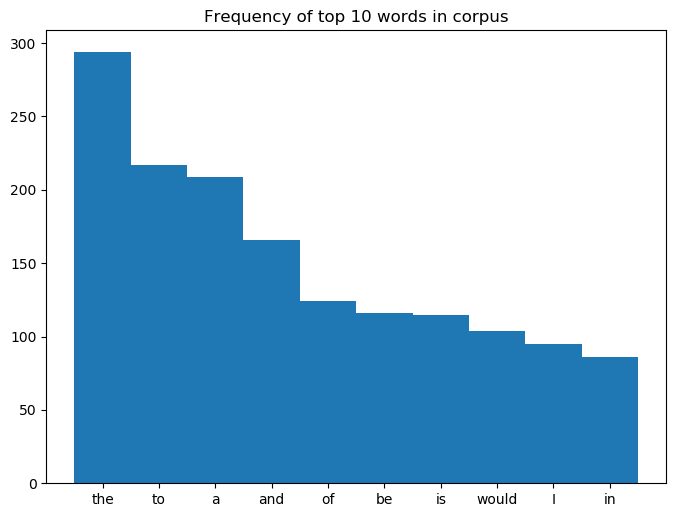

In [11]:
full_text = ' '.join(text for text in df['comment']).split()


def plot_top_10_words(texts: list):
    """Plots the top 10 words in a strings list"""
    labels, values = zip(*Counter(texts).most_common(10))

    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels)
    plt.title('Frequency of top 10 words in corpus')
    plt.show()


plot_top_10_words(full_text)

#### Word Cloud

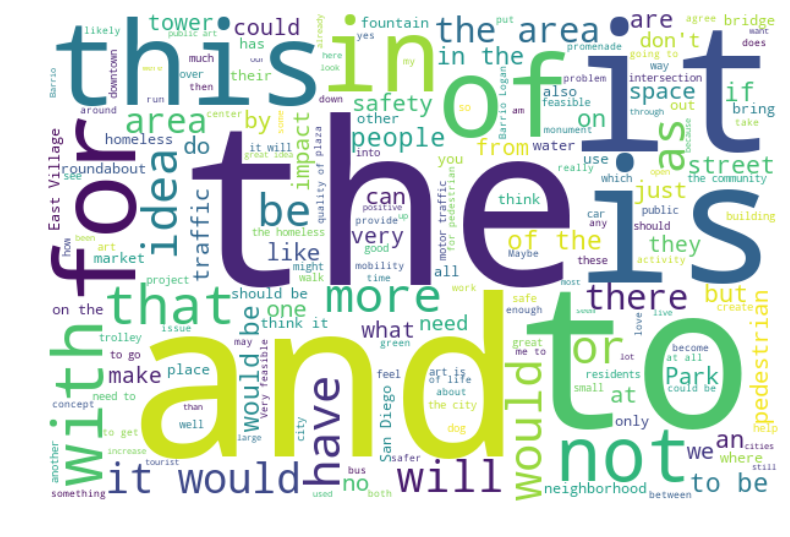

In [12]:
# Generate a word cloud image
def plot_word_cloud(text: str, stopwords=None, title='', filename=None):
    """Given string full of whitespace-delimited words, plots a word cloud"""
    wordcloud = WordCloud(width=600,
                          height=400,
                          background_color="white",
                          stopwords=stopwords,).generate(text)
    fig, ax = plt.subplots()
    ax.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.title(title)
    if filename:
        plt.savefig(filename)


plot_word_cloud(text=' '.join(full_text), stopwords=[])

Well that's not so informative! We'll need some text preprocessing before we get anywhere and cut through linguistic noise. For now, hold on to that thought, we'll get back to it later.

### Preprocess

In [13]:
custom_stop_words = ['the', 'for', 'can', 'this', 'i.e.', 'm', 's', 'e',
                    't', 'use', 'what', 'it', 'will', 'just']

In [14]:
def all_digits(n):
    """Returns True if string n contains all digits"""
    return all(i in string.digits for i in n)


def preprocess_docs(documents):
    # Set up word handling
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = get_stop_words('en') + custom_stop_words
    assert 'and' in en_stop
    p_stemmer = PorterStemmer()

    # Perform the clustering
    texts = []
    for doc in documents:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)

        # Remove stop words and numbers from tokens
        stopped_tokens = [
            i for i in tokens if i not in en_stop and not all_digits(i)]
        assert 'this' not in stopped_tokens
        
        texts.append(stopped_tokens)
    return texts


comments = preprocess_docs(df['comment'].values)
print(len(comments), 'comments pre-processed')

355 comments pre-processed


### Bigrams
For words like "New York", we need to have them as separate entities, and not just "New" and "York". These are called bigrams, and we'll add them to the corpus. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [15]:
# Build the bigram and trigram models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(comments, min_count=4)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

comments = [bigram_mod[comment] for comment in comments]
processed_text = sum(comments, [])

In [16]:
# Link it back to original DataFrame
df['processed'] = [' '.join(comment) for comment in comments]
df.sample(2)

,comment,idea_id,task_id,user_id,created_at,processed
313,Why not make everyone with these ideas happy. ...,10,5,120,8/30/2017 6:08,make everyone ideas happy tower small park nex...
163,It only impacts safety if people use it. Righ...,22,14,65,8/23/2017 23:28,impacts safety people right_now aren many pede...


Now! Let's look at the word distribution

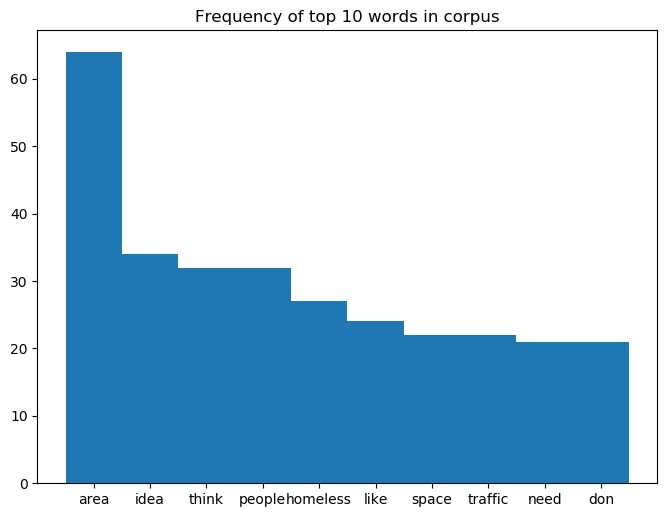

In [17]:
plot_top_10_words(processed_text)

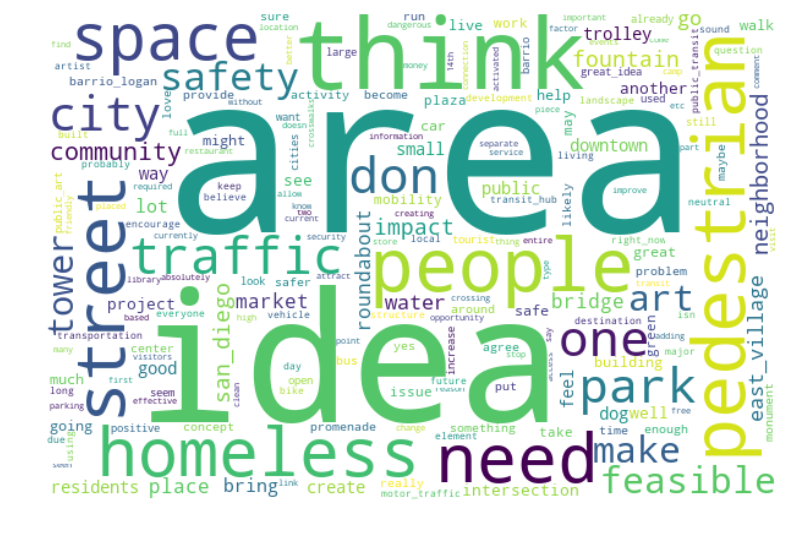

In [18]:
plot_word_cloud(' '.join(processed_text))

## Sentiment Analysis
From Wikipedia:
>Sentiment analysis aims to **determine the attitude** of a speaker, writer, or other subject with respect to some topic or the overall contextual **polarity or emotional reaction** to a document, interaction, or event.

The implementation we're using here was trained on a large dataset of movie reviews, so that given a piece of text, it can give a prediction as to whether the content is positive or negative.

In [19]:
TextBlob('This is absolutely amazing!').sentiment

Sentiment(polarity=0.7500000000000001, subjectivity=0.9)

In [20]:
TextBlob('The outlook is very bad.').sentiment

Sentiment(polarity=-0.9099999999999998, subjectivity=0.8666666666666667)

#### Standford NLP

In [25]:
def sentimentAnalytics (df):
    results = []
    sa = {}
    res = nlp.annotate(str(df),
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json',
                       'timeout': 1000,
                   })
    for i in json.loads(res)['sentences']:
        sa["sentimentValue"] = i["sentimentValue"]
        sa["sentiment"] = i["sentiment"]
        results.append(sa)
    return results

def processSentiment(df, num):
    res = sentimentAnalytics(df)
    result = ""
    if (num==0):
        for i in res:
            result += str(i['sentiment']) + ","
    else:
        for i in res:
            result += str(i["sentimentValue"]) + ","
    return result

In [26]:
df['polarity'], df['subjectivity_score'] = zip(
    *df['comment'].apply(lambda x: TextBlob(x).sentiment))

df['sentiment'] = df['polarity'].apply(
    lambda x: 'Negative' if x < 0 else 'Positive')

df['sentiment_corenlp'] = df['comment'].apply(
    lambda x: processSentiment(x, 0))

df['subjectivity_score_corenlp'] = df['comment'].apply(
    lambda x: processSentiment(x, 1))

df['subjectivity'] = df['subjectivity_score'].apply(
    lambda x: 'Fact' if x < 0.5 else 'Opinion')

df['profanity'] = df['comment'].apply(
    lambda x: predict_prob([x])[0])

df.sample(50)

,comment,idea_id,task_id,user_id,created_at,processed,polarity,subjectivity_score,sentiment,sentiment_corenlp,subjectivity_score_corenlp,subjectivity,profanity
278,Until more adequate housing options are availa...,33,17,111,8/30/2017 0:52,adequate housing options available people expe...,0.445833,0.495833,Positive,"Negative,","1,",Fact,0.083416
295,Absolutely not. What would be the draw to brin...,6,12,120,8/30/2017 5:51,absolutely draw bring people area small monume...,-0.010185,0.487963,Negative,"Negative,Negative,Negative,Negative,Negative,N...","1,1,1,1,1,1,1,1,1,",Fact,0.024627
361,Well it would definitely increase traffic in t...,35,15,125,8/30/2017 21:55,well definitely increase traffic area market d...,0.069048,0.326984,Positive,"Negative,Negative,","1,1,",Fact,0.004118
62,This doesn't seem that feasible due to the tro...,3,6,32,8/10/2017 21:55,doesn seem feasible due trolley tracks need co...,0.125000,0.525000,Positive,"Negative,","1,",Opinion,0.035555
271,Agreed,6,10,110,8/30/2017 0:42,agreed,0.000000,0.000000,Positive,"Neutral,","2,",Fact,0.096785
305,Tax dollars on 24/7 quality security.,4,12,120,8/30/2017 6:00,tax dollars quality security,0.000000,0.000000,Positive,"Negative,","1,",Fact,0.057178
316,This property needs to be used to its fullest ...,27,5,120,8/30/2017 6:10,property needs used fullest capability place s...,0.100000,1.000000,Positive,"Positive,Positive,","3,3,",Opinion,0.159912
349,Action!,25,17,121,8/30/2017 17:14,action,0.125000,0.100000,Positive,"Neutral,","2,",Fact,0.108360
238,It could have a positive impact by connecting ...,25,16,84,8/29/2017 5:35,positive impact connecting bus trolley service...,0.242424,0.348485,Positive,"Negative,","1,",Fact,0.052353
121,People would have more access to public transit.,14,16,54,8/21/2017 21:28,people access public_transit,0.250000,0.283333,Positive,"Neutral,","2,",Fact,0.080296


### Sentiment
#### Most positive

In [ ]:
for comment in df.nlargest(NUM, 'polarity')['comment'].values:
    print(comment, '\n---')

#### Most negative

In [ ]:
for comment in df.nsmallest(NUM, 'polarity')['comment'].values:
    print(comment, '\n---')

### Subjectivity
#### Most subjective

In [ ]:
for comment in df.nlargest(NUM, 'subjectivity_score')['comment'].values:
    print(comment, '\n---')

#### Most objective

In [ ]:
for comment in df.nsmallest(NUM, 'subjectivity_score')['comment'].values:
    print(comment, '\n---')

## Named Entity Recognition

    conda install -c conda-forge spacy
    python -m spacy download en

In [31]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [32]:
relevant_labels = [
    'PERSON',
    'NORP',
    'FAC',
    'ORG',
    'GPE',
    'LOC',
    'PRODUCT',
    'LAW',
]


def get_entities(string):
    """Given input string, returns list of names entities"""
    return [ent.text for ent in nlp(string).ents if ent.label_ in relevant_labels and ent.text != '\n']


df['named_entities'] = df['comment'].apply(lambda x: get_entities(str(x)))

#### standford nlp

In [30]:
# nlp = StanfordCoreNLP(r'/Users/dennis/NLP/stanford-corenlp-full-2018-10-05')
def corenlpentity(comment):
    results = ""
    gen = (x for x in nlp.ner(str(comment)) if str(x[1]) != "O")
    for tag, chunk in groupby(gen, lambda x:x[1]):
        if tag != "O":
            results += tag + "-" + " ".join(w for w, t in chunk) +","
    return results

# corenlpentity("It would bring lots of excitement and will bring the community closer. It can also be an offsite location for museum of contemporary art in San Diego.")
df['named_entities_corenlp'] = df['comment'].apply(lambda x: corenlpentity(str(x)))

In [33]:
df[df.astype(str)['named_entities'] != '[]'].sample(5)

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

                                               comment  idea_id  task_id  \
71   merge art and culture of East Village with tha...        6        9   
90   Roundabouts are most commonly used internation...        3        6   
381  Very feasible.  It's just about changing creat...       15        6   
393  It's dangerous and would need to be partnered ...       24       16   
364  Beautiful, but we already have an iconic pedes...       34       10   

     user_id       created_at  \
71        35  8/10/2017 22:35   
90        45   8/15/2017 2:38   
381      128  8/31/2017 16:20   
393      128  8/31/2017 17:40   
364      124  8/30/2017 22:01   

                                             processed  polarity  \
71   merge art culture east_village barrio_logan ce...  0.000000   
90   roundabouts commonly used internationally yet ...  0.000000   
381  feasible changing creature habits also work ci...  0.200000   
393  dangerous need partnered san_diego tourism aut... -0.050000   
364 

In [ ]:
df

## Latent Dirichlet Allocation (LDA) Topic Model
### Train

In [ ]:
dictionary = corpora.Dictionary(comments)
corpus = [dictionary.doc2bow(comment) for comment in comments]

In [ ]:
models = []
for num in tqdm(range(2, 30)):
    ldamodel = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=num)
    coherence = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    models.append((num, ldamodel, coherence.get_coherence()))

In [ ]:
df_models = pd.DataFrame(models)
df_models.head(10)

In [ ]:
df_models[2].plot()

In this case, let's go with `n=9` as the optimal number of topics. We already know that comments usually mention multiple topics in the same go, so this small number still can intuitively make sense.

In [ ]:
ldamodel = df_models[df_models[0] == 9][1].values[0]

### Visualize the model

In [ ]:
visualization = viz.prepare(ldamodel, corpus, dictionary)
filename_viz = 'ldaviz.html'
pyLDAvis.save_html(visualization, filename_viz)

# visualization

### Top topic per comment

In [ ]:
# TODO: Join to main df instead of creating a new one
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=df['comment']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences()

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

### Augmenting the dataset with most salient topic per comment

In [ ]:
df_final = pd.merge(df, df_dominant_topic, left_on=df.index, right_on='Document_No')
for col in ['Document_No', 'Keywords', 'Text']:
    try:
        del df_final[col]
    except:
        pass

df_final.sample(5)

In [ ]:
# Finally, clean the entities column
df_final['named_entities'] = df_final['named_entities'].apply(lambda x: '; '.join(set(e for e in x)))
df_final.sample(5)

In [ ]:
# We get a few comments that can't be assigned to any topic
len(df_final[df_final['Dominant_Topic'].isnull()])

In [ ]:
print(df_final[df_final['Dominant_Topic'].isnull()]['comment'].sample().values[0])

That one is odd, seems like it should definitely sit with topic #5 or #7. Oh well!

In [ ]:
df_final['Dominant_Topic'].plot.hist(bins=5)

### Word clouds by topic

In [ ]:
for topic in sorted(df_final['Dominant_Topic'].unique()):
    if np.isnan(topic):
        continue
    texts = df_final[df_final['Dominant_Topic'] == topic]['processed'].values
    title_ = 'Topic ' + str(int(topic + 1))
    filename_ = 'wordcloud_' + str(int(topic + 1))
    plot_word_cloud(' '.join(texts), title=title_, filename=filename_)

In [ ]:
# Show data
for topic in sent_topics_sorteddf_mallet.itertuples():
    print(f'# Topic {topic[0] + 1}:\n', topic[-1], '\n---')

## Summarizing topics

In [ ]:
for topic in sorted(df_final['Dominant_Topic'].unique()):
    if np.isnan(topic):
        continue
    comments = df_final[df_final['Dominant_Topic'] == topic]['comment']
    print('Topic:', int(topic + 1))
    print(summarize('\n'.join(c for c in comments), word_count=200))
    print('---')

In [ ]:
from collections import defaultdict

topics_kwargs = {
    0.0: 'Ban single use plastic',
    1.0: 'Recyclable paackaging',
    2.0: 'Replace fast food packaging',
    3.0: 'Ban non-biodegradable packaging',
    4.0: 'Regulate non-biodegradable packaging',
    5.0: 'Financial incentives for compostable products',
    6.0: 'Promote better recycling practices',
    7.0: 'Research alternative materials',
    8.0: 'Make companies responsible for their waste',
}
topics = defaultdict(lambda: 'No topic detected', topics_kwargs)

df_final['topic'] = df_final['Dominant_Topic'].apply(lambda x: topics[x])
df_final.sample(5)

## Save to CSV

In [34]:
df.to_csv('text_analytics_v2_withoutLDA2.csv', index=False, encoding='utf8')